In [245]:
#Reference https://github.com/srafay/Time-Series-Analysis-JetRail/blob/master/Jet_Rail.py

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plot

In [247]:
# Pre Processing the data
data = pd.read_csv('data/train.csv')

# Prepare the date time index
data.index = pd.DatetimeIndex(pd.to_datetime(data['Datetime']))

# Drop columns
data.drop('Datetime', axis=1, inplace=True)
data.drop('ID', axis=1, inplace=True)

In [248]:
data.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [249]:
data.describe()

,Count
count,18288.000000
mean,138.958115
std,153.467461
min,2.000000
25%,22.000000
50%,84.000000
75%,210.000000
max,1244.000000


In [280]:
total_count = int(len(data))
train_start = 0
train_end = int(0.7*total_count)
valid_start = train_end + 1

train = data[:train_end] 
train.index = data.index[:train_end]
valid = data[train_end:]
valid.index = data.index[train_end:]

In [281]:
train.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [282]:
valid.head()

,Count
Datetime,
2014-09-02 09:00:00,212
2014-09-02 10:00:00,196
2014-09-02 11:00:00,180
2014-09-02 12:00:00,188
2014-09-02 13:00:00,182


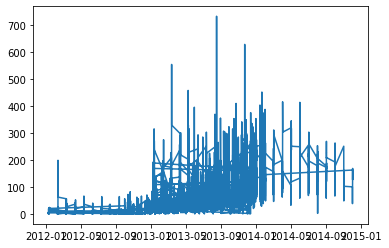

In [283]:
plot.plot(train)

In [284]:
from statsmodels.tsa.stattools import adfuller
def test_stability(ts):
    # rolling mean ann std for a day, 24 hours
    rollingmean = ts.rolling(24).mean()
    rollingstd = ts.rolling(24).std()
    
    plot.plot(ts, color='blue', label='original')
    plot.plot(rollingmean, color='red', label='Rolling Mean')
    plot.plot(rollingstd, color='green', label='Rolling Std')
    plot.title("Rolling Mean and STD")
    plot.show(block=False)
    
    # Dicky Fuller Test
    print ('Dicky Fuller Test:')
    dickyfullertest = adfuller(ts, autolag='AIC')
    dickyfulleroutput = pd.Series(
        dickyfullertest[0:4],
        index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    )
    for key, value in dickyfullertest[4].items():
        dickyfulleroutput['Critical Value (%s)'%key] = value
    
    print (dickyfulleroutput)
    

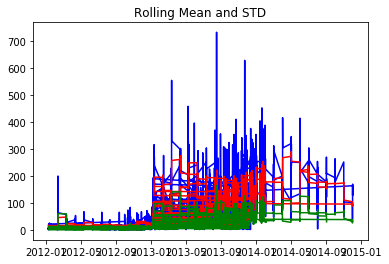

Dicky Fuller Test:
Test Statistic                -5.784737e+00
p-value                        5.030012e-07
#Lags Used                     4.100000e+01
Number of Observations Used    1.275900e+04
Critical Value (1%)           -3.430863e+00
Critical Value (5%)           -2.861767e+00
Critical Value (10%)          -2.566891e+00
dtype: float64


In [285]:
test_stability(train)

In [286]:
trainlog = np.log(train)

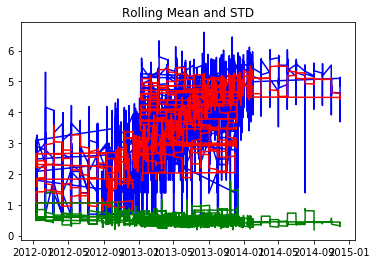

Dicky Fuller Test:
Test Statistic                    -4.094950
p-value                            0.000987
#Lags Used                        41.000000
Number of Observations Used    12759.000000
Critical Value (1%)               -3.430863
Critical Value (5%)               -2.861767
Critical Value (10%)              -2.566891
dtype: float64


In [287]:
test_stability(trainlog)

In [288]:
trainma = trainlog.rolling(24).mean()
trainlogmadiff = trainlog - trainma
trainlogmadiff.dropna(inplace=True)

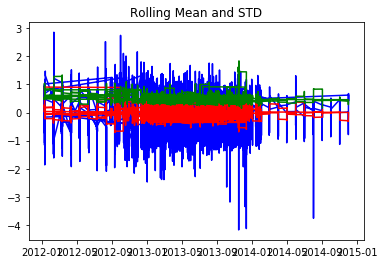

Dicky Fuller Test:
Test Statistic                   -22.968769
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12737.000000
Critical Value (1%)               -3.430864
Critical Value (5%)               -2.861767
Critical Value (10%)              -2.566891
dtype: float64


In [289]:
test_stability(trainlogmadiff)

In [290]:
trainlogdiff = trainlog - trainlog.shift(1)
trainlogdiff.dropna(inplace=True)

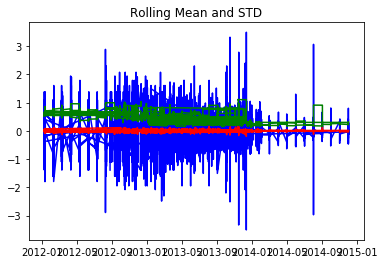

Dicky Fuller Test:
Test Statistic                   -23.001629
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    12758.000000
Critical Value (1%)               -3.430863
Critical Value (5%)               -2.861767
Critical Value (10%)              -2.566891
dtype: float64


In [291]:
test_stability(trainlogdiff)

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(pd.DataFrame(trainlog).Count.values, period = 24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
print (trend)
print (seasonal)
print (residual)

[nan nan nan ... nan nan nan]
[ 0.22054824 -0.03859044 -0.20534288 ... -0.63479446 -0.5160059
 -0.34908538]
[nan nan nan ... nan nan nan]


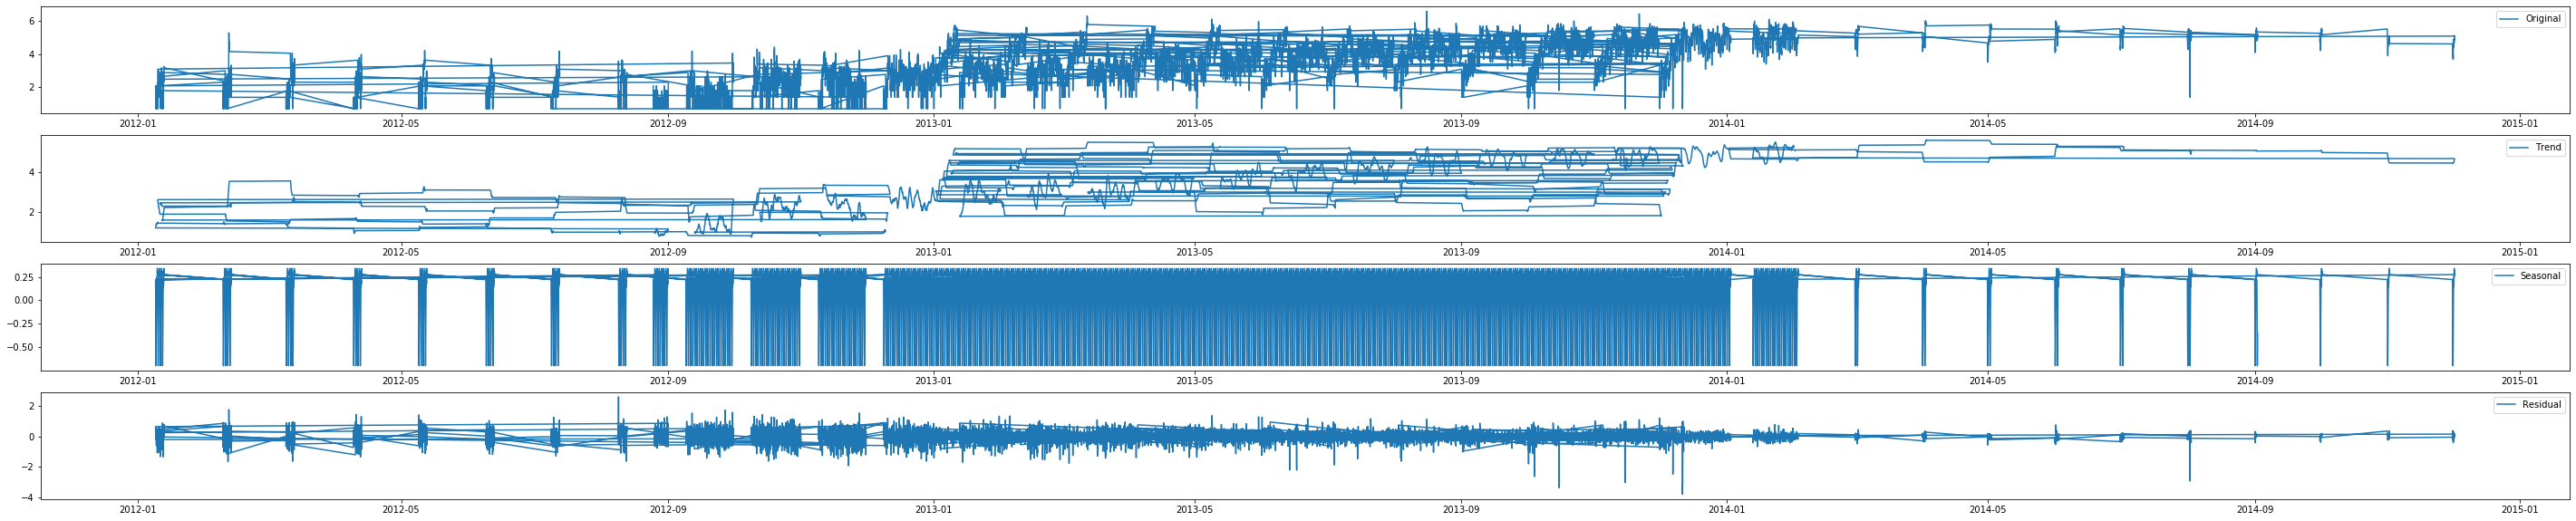

In [293]:
plot.figure(figsize=(50,10))
plot.subplot(411)
plot.plot(train.index, trainlog, label='Original')
plot.legend(loc='best')
plot.subplot(412)
plot.plot(train.index, trend, label='Trend')
plot.legend(loc='best')
plot.subplot(413)
plot.plot(train.index, seasonal, label='Seasonal')
plot.legend(loc='best')
plot.subplot(414)
plot.plot(train.index, residual, label='Residual')
plot.legend(loc='best')
plot.show()

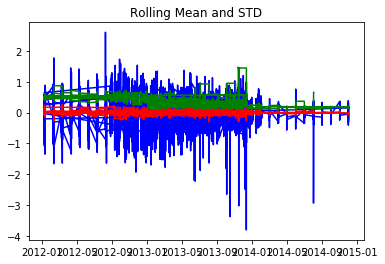

Dicky Fuller Test:
Test Statistic                   -28.348603
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    12735.000000
Critical Value (1%)               -3.430864
Critical Value (5%)               -2.861767
Critical Value (10%)              -2.566891
dtype: float64


In [294]:
trainlogdecompose = pd.DataFrame(residual)
trainlogdecompose.index = train.index
trainlogdecompose.dropna(inplace=True)
test_stability(trainlogdecompose)

In [295]:
# User ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(trainlogdiff,nlags=25, fft=False)
lag_pacf = pacf(trainlogdiff, nlags=25, method='ols')

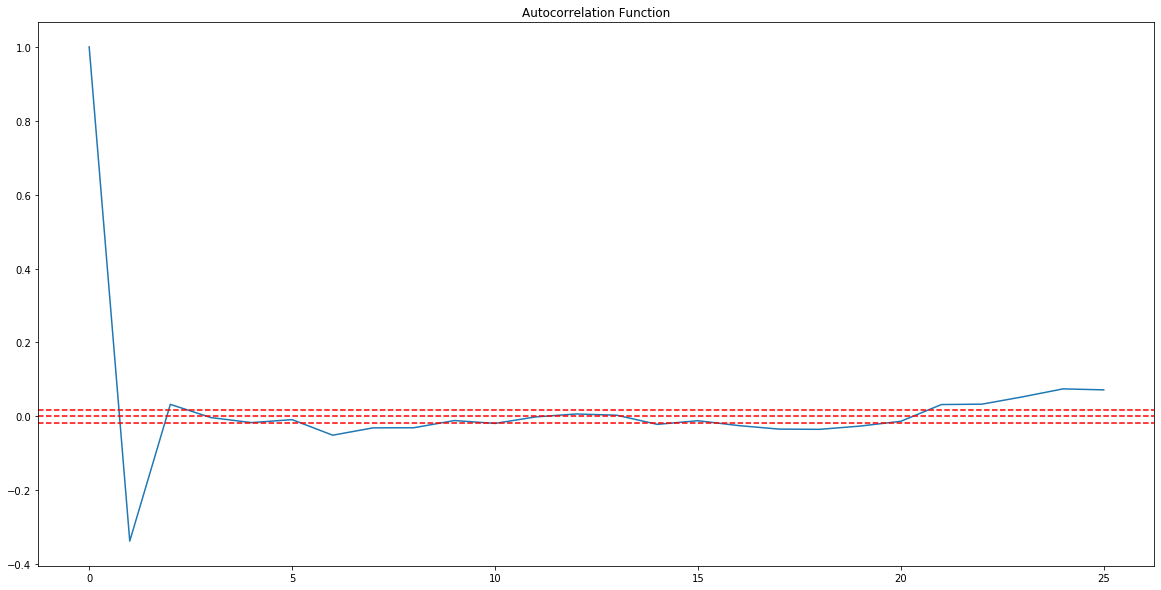

In [296]:
plot.figure(figsize=(20,10))
plot.plot(lag_acf)
plot.axhline(y=0, linestyle='--', color='red')
plot.axhline(y=-1.96/np.sqrt(len(trainlogdiff)), linestyle='--', color='red')
plot.axhline(y=1.96/np.sqrt(len(trainlogdiff)), linestyle='--', color='red')
plot.title('Autocorrelation Function')
plot.show()


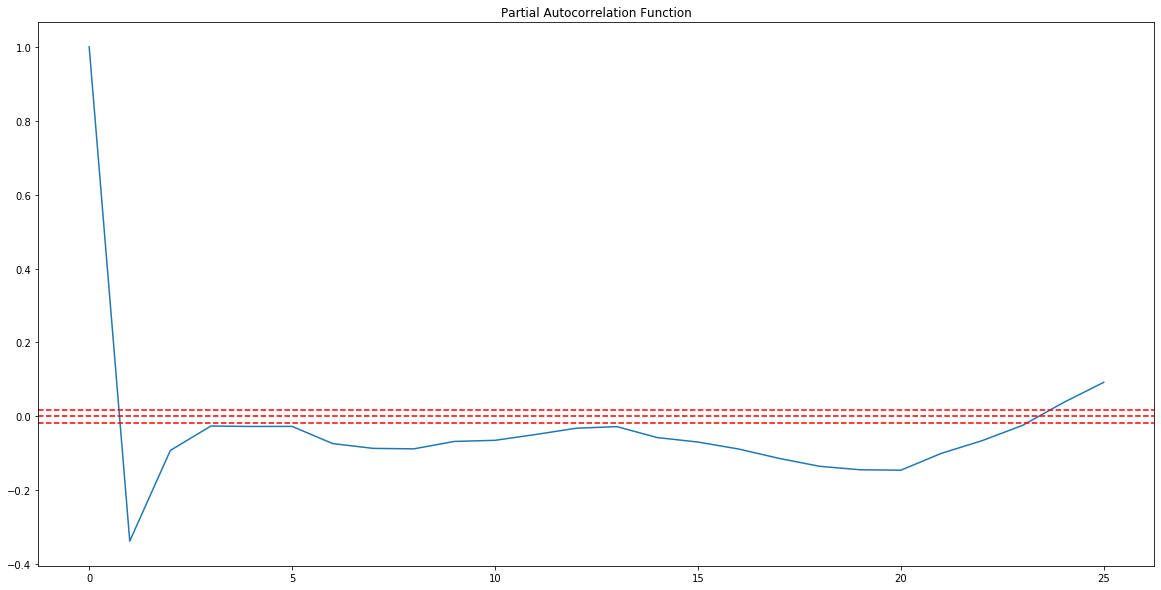

In [297]:
plot.figure(figsize=(20,10))
plot.plot(lag_pacf)
plot.axhline(y=0, linestyle='--', color='red')
plot.axhline(y=-1.96/np.sqrt(len(trainlogdiff)), linestyle='--', color='red')
plot.axhline(y=1.96/np.sqrt(len(trainlogdiff)), linestyle='--', color='red')
plot.title('Partial Autocorrelation Function')
plot.show()


/Users/pdhingra/miniconda3/envs/av/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/pdhingra/miniconda3/envs/av/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/pdhingra/miniconda3/envs/av/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/pdhingra/miniconda3/envs/av/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueW

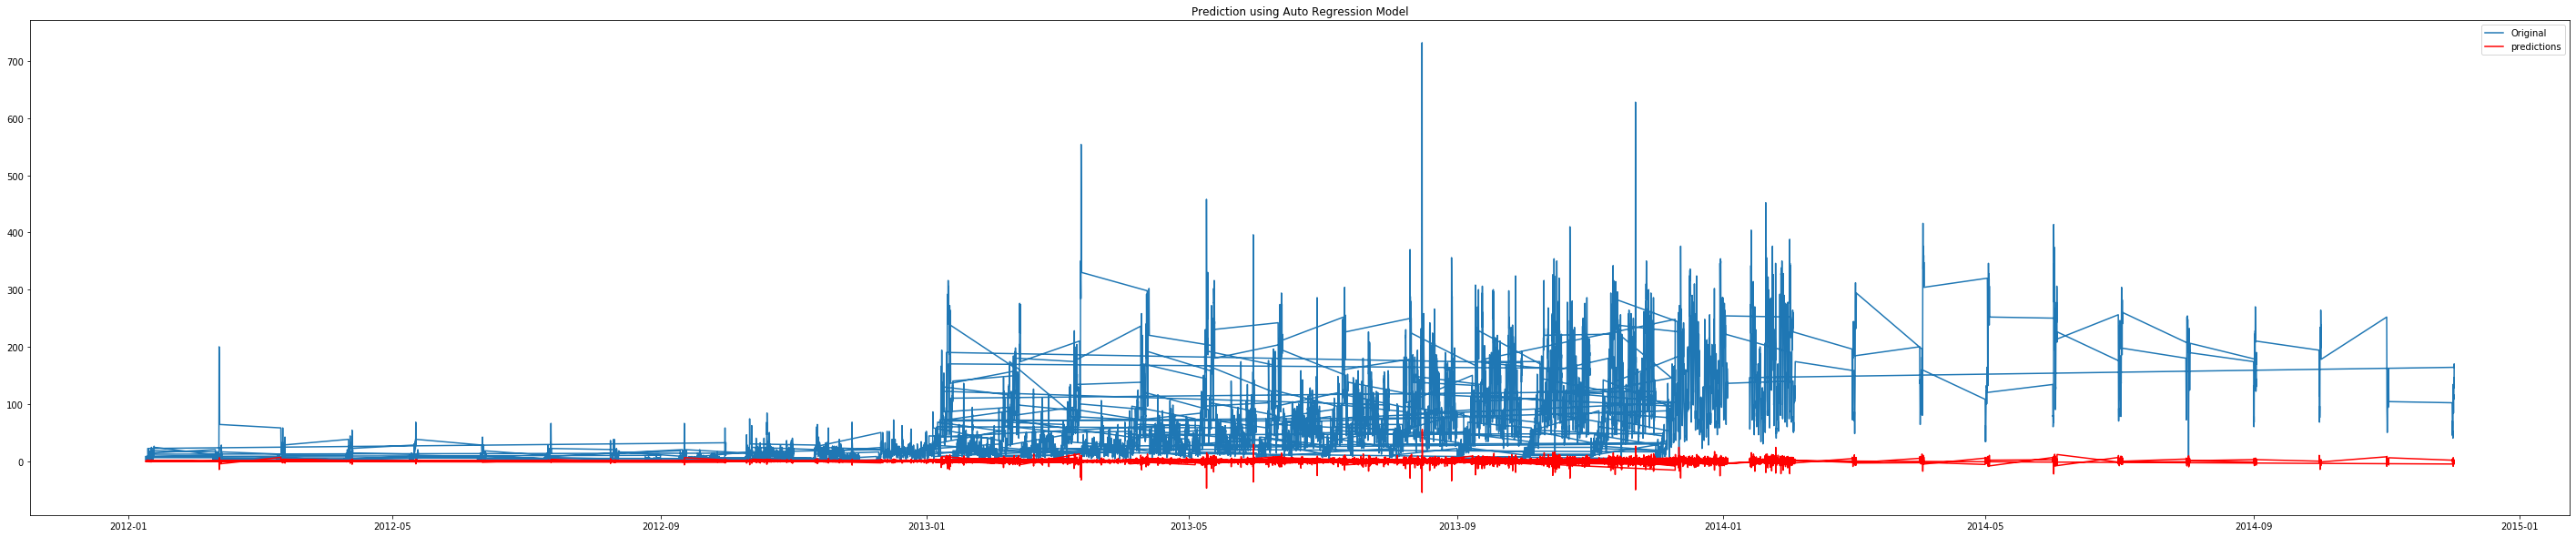

In [298]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1,1,0))
result_AR = model.fit(disp=-1)
plot.figure(figsize=(50,10))
plot.plot(train, label = 'Original')
plot.plot(result_AR.fittedvalues, color='red', label = 'predictions')
plot.title ('Prediction using Auto Regression Model')
plot.legend(loc='best')
plot.show()



In [315]:
AR_predict = result_AR.predict(start=train_end, end=total_count-1)
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count']), index=valid.index)
AR_predict.index = valid.index
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
AR_predict = np.exp(AR_predict1)


/Users/pdhingra/miniconda3/envs/av/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


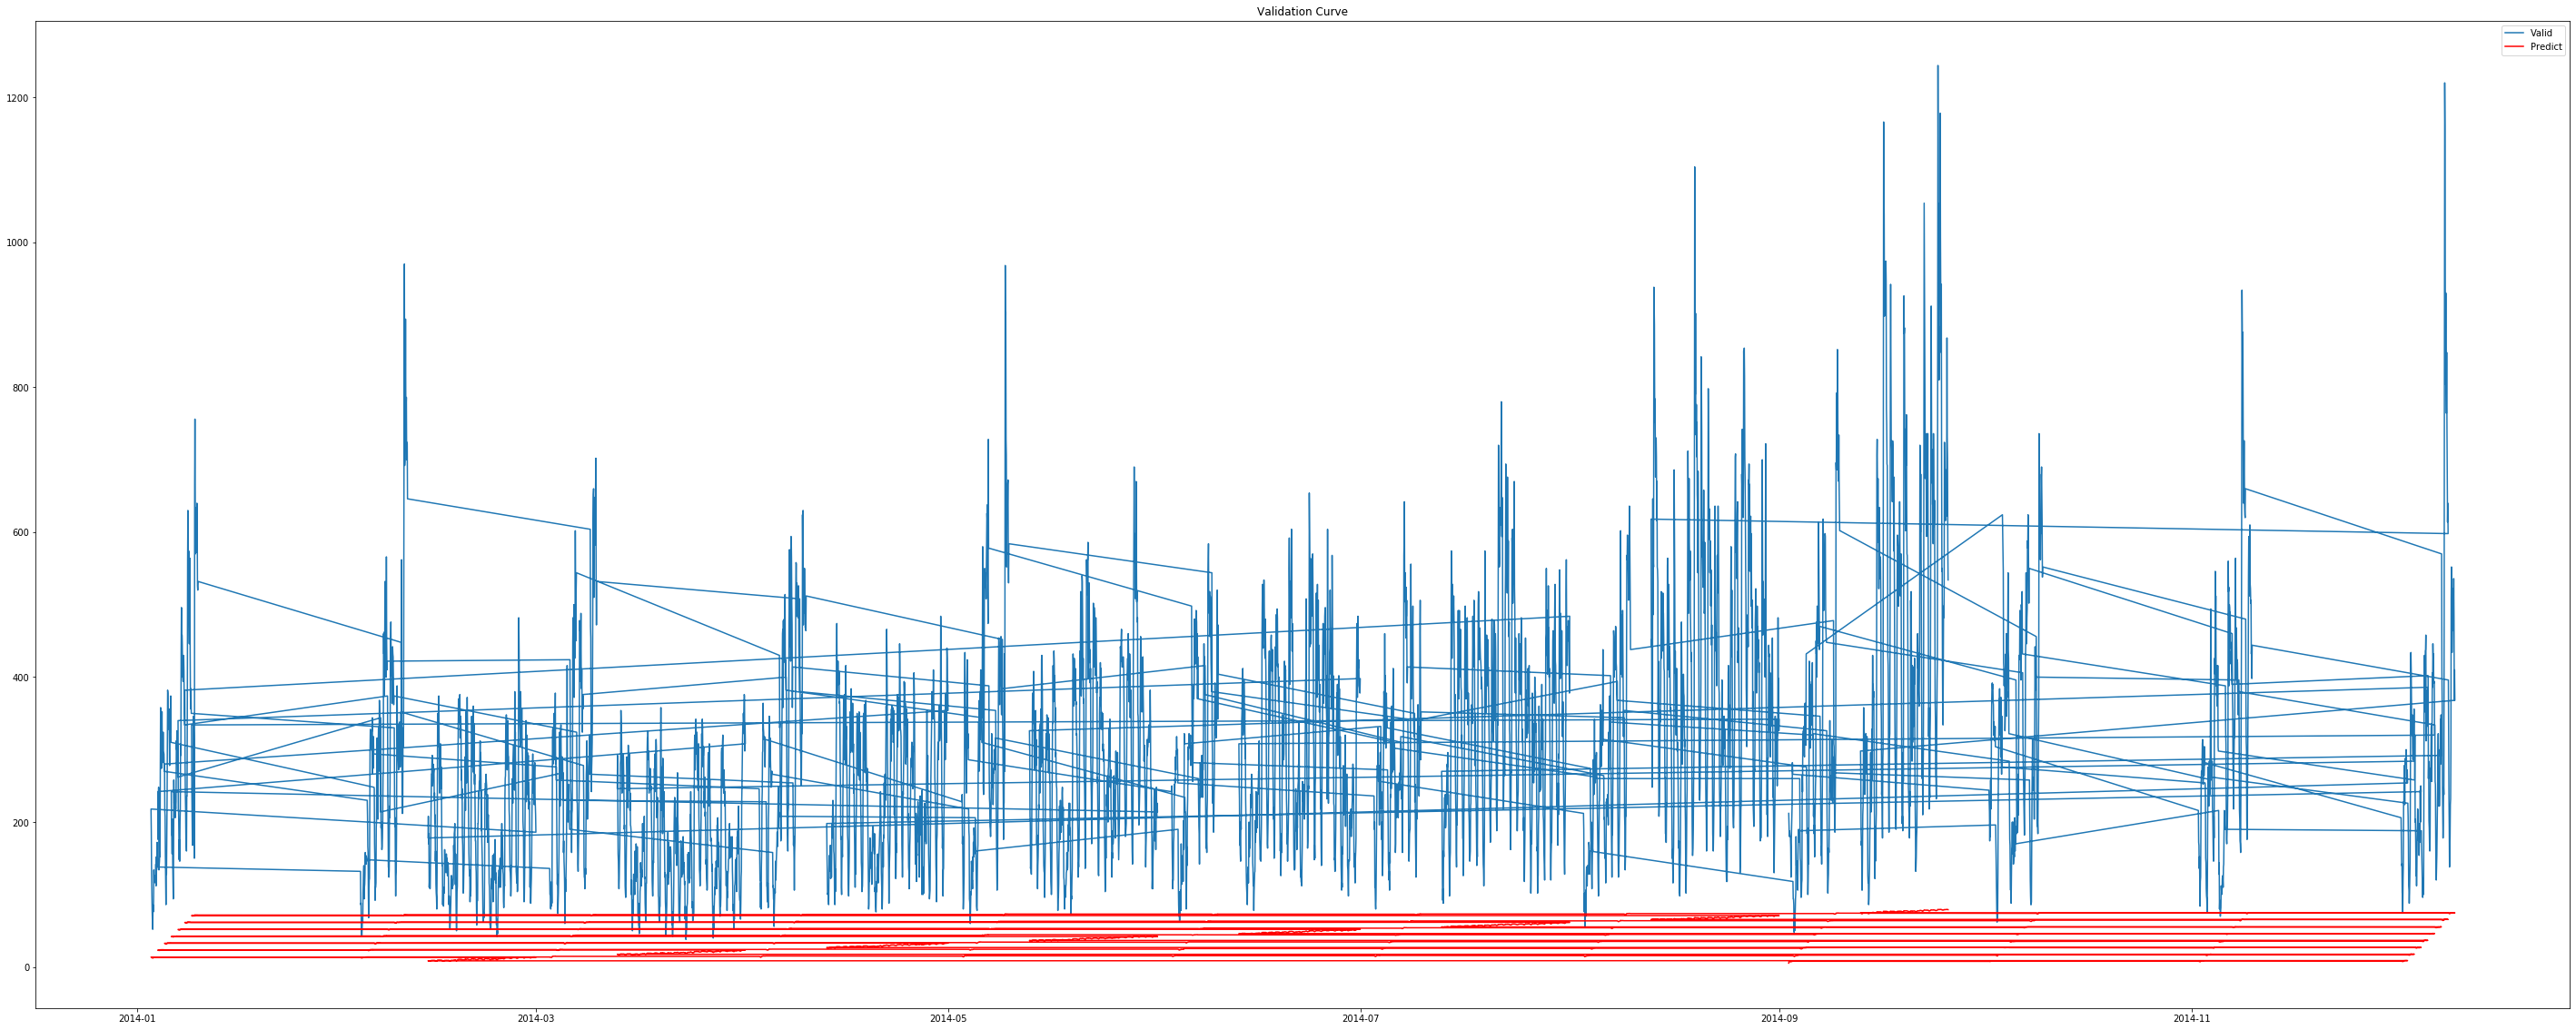

In [316]:
plot.figure(figsize=(50,20))
plot.plot(valid['Count'], label='Valid')
plot.plot(AR_predict1, color='red',label='Predict')
plot.legend(loc='best')
plot.title("Validation Curve")
plot.show()

In [317]:
AR_predict1

Datetime
2014-09-02 09:00:00     5.356586
2014-09-02 10:00:00     7.782089
2014-09-02 11:00:00     7.399729
2014-09-02 12:00:00     7.494687
2014-09-02 13:00:00     7.470324
                         ...    
2014-09-25 19:00:00    79.570614
2014-09-25 20:00:00    79.413079
2014-09-25 21:00:00    79.384109
2014-09-25 22:00:00    79.206080
2014-09-25 23:00:00    79.136324
Length: 5487, dtype: float64

In [302]:
valid

,Count
Datetime,
2014-09-02 09:00:00,212
2014-09-02 10:00:00,196
2014-09-02 11:00:00,180
2014-09-02 12:00:00,188
2014-09-02 13:00:00,182
...,...
2014-09-25 19:00:00,868
2014-09-25 20:00:00,732
2014-09-25 21:00:00,702


In [303]:
5487*2

10974

In [304]:
train_end

12801

In [305]:
total_count

18288